# Projet Chlordécone aux Antilles - Volet 1 : Ingénierie des données
**Auteur : Maxendre Bauthamy**

Ce notebook rassemble toutes les étapes de nettoyage, de transformation et de structuration de la base de données brute "BaseCLD2026.csv".

In [ ]:
# Chargement des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration visuelle pour les graphiques
sns.set_theme(style="whitegrid")

## 1. Importation et inspection des données brutes
Chargement du fichier "BaseCLD2026.csv" avec aperçu du jeu de données.

In [34]:
# Chargement des données brutes
chemin_fichier = '../data/raw/BaseCLD2026.csv'
df = pd.read_csv(chemin_fichier, sep=';', low_memory=False)

# Dimension du DataFrame des données brutes
print(f"Dimensions initiales : {df.shape[0]} lignes et {df.shape[1]} colonnes.\n")

# Aperçu du DataFrame des données brutes
display(df.head(3))

Dimensions initiales : 31126 lignes et 22 colonnes.



,ID,ANNEE,COMMU_LAB,RAIN,Sol_simple,type_sol,Date_prelevement,Date_enregistrement,Date_analyse,Operateur_chld,Taux_Chlordecone,Operateur_5b,Taux_5b_hydro,histoBanane_Histo_ban,mnt_tpi_mean,mnt_tri_mean,mnt_rugosite_mean,mnt_ombrage_mean,mnt_exposition_mean,mnt_pente_mean,X,Y
0,20143,2010,GROS-MORNE,2000-3000,Andosol,Intergrades Sols … allophane relativement ‚vol...,24/05/2007,24/05/2007,24/05/2007,=,4.6,=,"0,07",2.0,5.805967,8.033367,21.593658,131.173998,79.447954,39.043098,714300.831892,1.626344e+06
1,20143,2010,GROS-MORNE,2000-3000,Andosol,Intergrades Sols … allophane relativement ‚vol...,24/05/2007,24/05/2007,24/05/2007,=,4.6,=,"0,07",2.0,5.683589,7.920563,20.944901,134.608205,76.985690,38.123675,714303.743345,1.626354e+06
2,20143,2010,GROS-MORNE,2000-3000,Andosol,Intergrades Sols … allophane relativement ‚vol...,24/05/2007,24/05/2007,24/05/2007,=,4.6,=,"0,07",3.0,2.239457,7.108432,20.085883,139.420523,76.064719,34.976678,714309.446765,1.626360e+06


## 2. Recodage des modalités et transformation
Les données brutes comportent des incohérences :
* Des virgules à la place des points pour les décimales.
* Des caractères parasites comme `=` ou `<` dans les colonnes numériques.
* Des dates au format texte qu'il faut convertir en objet `datetime`.

In [35]:
# Nettoyage des variables numériques
cols_taux = ['Taux_Chlordecone', 'Taux_5b_hydro']

for col in cols_taux:
    df[col] = df[col].astype(str)
    # Suppression des caractères parasites
    df[col] = df[col].str.replace('=', '', regex=False).str.replace('<', '', regex=False)
    # Remplacement de la virgule par un point
    df[col] = df[col].str.replace(',', '.', regex=False)
    # Conversion en numérique
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [36]:
# Conversion des formats de dates
cols_dates = ['Date_prelevement', 'Date_enregistrement', 'Date_analyse']

for col in cols_dates:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')

## 3. Valeurs manquantes et data cleaning
Avant de nettoyer, nous devons visualiser les données manquantes du jeu de données.

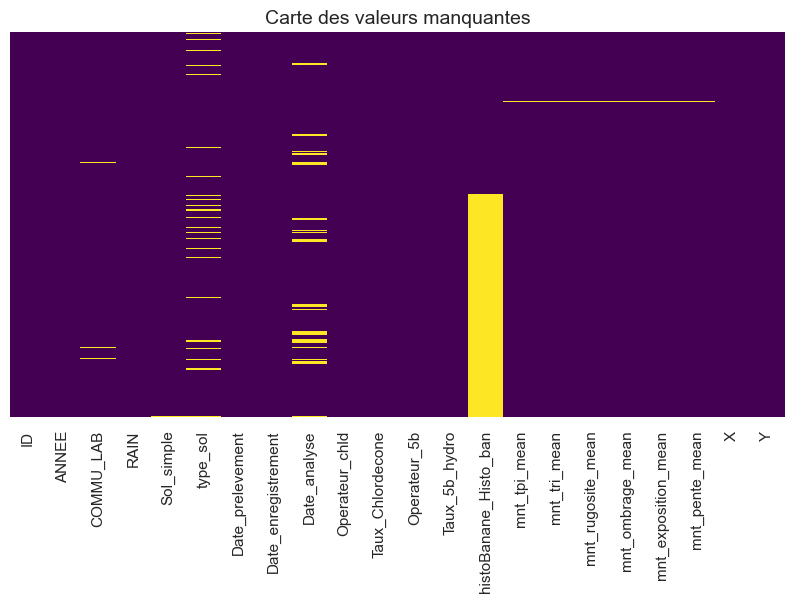

In [37]:
# Visualisation des valeurs manquantes
plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Carte des valeurs manquantes", fontsize=14)
plt.show()

In [38]:
# Comptage des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isna().sum()[df.isna().sum() > 0])

Valeurs manquantes par colonne :
COMMU_LAB                  298
Sol_simple                  74
type_sol                  2609
Date_analyse              2702
Taux_5b_hydro               23
histoBanane_Histo_ban    17983
mnt_tpi_mean                28
mnt_tri_mean                28
mnt_rugosite_mean           28
mnt_ombrage_mean            28
mnt_exposition_mean         28
mnt_pente_mean              28
dtype: int64


**Recodage et stratégies d’imputation :**
1. **Topographie (`mnt_...`) :** Seulement 28 valeurs manquantes. Suppression des lignes.
2. **Catégories (`COMMU_LAB`, `Sol_simple`, etc.) :** Remplacement par la modalité "INCONNU".
3. **Cas extrême (`histoBanane...`) :** +50% de valeurs manquantes, création de la modalité "Non Renseigné".
4. **Taux_5b_hydro :** Imputation par la médiane.

In [39]:
# Suppression des lignes vides
df = df.dropna(subset=['mnt_pente_mean'])

# Remplacement par la modalité "INCONNU"
cols_categorielles = ['COMMU_LAB', 'Sol_simple', 'type_sol']
for col in cols_categorielles:
    df[col] = df[col].fillna('INCONNU')
    
# Création de la modalité "Non Renseigné"
df['histoBanane_Histo_ban'] = df['histoBanane_Histo_ban'].fillna('Non Renseigné')

# Imputation par la médiane
mediane_5b = df['Taux_5b_hydro'].median()
df['Taux_5b_hydro'] = df['Taux_5b_hydro'].fillna(mediane_5b)

print(f"Dimensions après data cleaning : {df.shape[0]} lignes.")

Dimensions après data cleaning : 31098 lignes.


## 4. Création de variables
On crée une nouvelle variable `Niveau_Pollution` en utilisant une fonction.

In [40]:
# Création d'une fonction "Niveau de Pollution"
def categoriser_pollution(taux):
    if pd.isna(taux):
        return 'Inconnu'
    elif taux < 0.1:    
        return 'Faible / Non détecté'
    elif taux <= 1.0:
        return 'Moyen'
    else:
        return 'Élevé'

# Application de la fonction
df['Niveau_Pollution'] = df['Taux_Chlordecone'].apply(categoriser_pollution)

# Vérification du compte des modalités
print(df['Niveau_Pollution'].value_counts())

Niveau_Pollution
Faible / Non détecté    20323
Élevé                    5550
Moyen                    5225
Name: count, dtype: int64


## 5. Agrégation des données
Nous allons ensuite agréger les données.

In [41]:
# Agrégation des données
analyse_communes = df.groupby('COMMU_LAB').agg(
    Taux_Moyen=('Taux_Chlordecone', 'mean'),
    Nb_Prelevements=('ID', 'count')
).reset_index()

# Top 5 des communes les plus polluées
top_communes = analyse_communes[analyse_communes['Nb_Prelevements'] > 50].sort_values(by='Taux_Moyen', ascending=False)

print("Top 5 des communes les plus polluées")
display(top_communes.head(5))

Top 5 des communes les plus polluées


,COMMU_LAB,Taux_Moyen,Nb_Prelevements
20,MORNE-ROUGE(LE),2.799778,3721
11,GRAND'RIVIERE,1.835210,124
17,MACOUBA,1.696910,697
2,BASSE-POINTE,1.381041,992
33,TRINITE(LA),0.680058,1096


## 6. Exportation des données propres
Le processus de Data Cleaning est terminé et reproductible. On exporte le jeu de données propre pour l'utiliser dans la suite du projet.

In [42]:
chemin_export = '../data/processed/BaseCLD_clean.csv'
df.to_csv(chemin_export, index=False)
print(f"Pipeline terminé : Données propres sauvegardées dans {chemin_export}")

Pipeline terminé : Données propres sauvegardées dans ../data/processed/BaseCLD_clean.csv
